In [1]:
from augur.utils import json_to_tree
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import numpy as np
import pandas as pd
from Bio import SeqIO
from collections import Counter
import requests
import random


Bad key "text.kerning_factor" on line 4 in
/Users/katekistler/anaconda3/envs/nextstrain/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


Find the probability of another mutation occuring within X (spotlight) branches or time, given that a mutation occurred on a branch

In [2]:
#Download tree json
tree_url = "https://data.nextstrain.org/ncov_global.json"

tree_json = requests.get(tree_url).json()

#Put tree in Bio.Phylo format
tree = json_to_tree(tree_json)

In [3]:
#Function to find path from root to clade
def get_parent(tree, child_clade):
    node_path = tree.get_path(child_clade)
    return node_path

In [4]:
# make dictionary where key is node and values are all children of node

node_children_dict = {}

for node in tree.find_clades(terminal=True):

    node_path = get_parent(tree, node)

    for parent_index in range(len(node_path)):

        parent = node_path[parent_index].name
        if parent not in node_children_dict.keys():
            node_children_dict[parent] = []

        children = node_path[parent_index+1:]

        for child in children:
            if child not in node_children_dict[parent]:
                node_children_dict[parent].append(child)

        


In [5]:
# add attribute with number of S1 or RdRp mutations that occurred at this node
for node in tree.find_clades():
    node.s1_muts_at_node = 0
    node.rdrp_muts_at_node = 0

    if hasattr(node, 'branch_attrs'):
        s1_muts_at_this_node = 0
        rdrp_muts_at_this_node = 0
        if 'S' in node.branch_attrs["mutations"]:
            for mut in node.branch_attrs["mutations"]['S']:
                mut_pos = int(mut[1:-1])
                if mut_pos in range(14,686):
                    s1_muts_at_this_node+=1



        elif "ORF1a" in node.branch_attrs["mutations"]:
            for mut in node.branch_attrs["mutations"]["ORF1a"]:
                if int(mut[1:-1]) in range(4492,4401):
                    rdrp_muts_at_this_node+=1

        elif "ORF1b" in node.branch_attrs["mutations"]:
            for mut in node.branch_attrs["mutations"]["ORF1b"]:
                if int(mut[1:-1]) in range(1,923):
                    rdrp_muts_at_this_node+=1


        node.s1_muts_at_node = s1_muts_at_this_node         
        node.rdrp_muts_at_node = rdrp_muts_at_this_node 

Depending on whether branch has an S1 mut or not, what is the probability that parents or children (within `spotlight`) has mutation


In [6]:
# spotlight_window_time = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]  

# spotlight_window_time = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6] 

# spotlight_window_time = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 
#                          0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0] 


spotlight_window_time = [0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5] 

# spotlight_window_time = list(np.arange(0.03,0.54, 0.03))

# proportion_nodes_w_mut = {f'minus_{x}':[] for x in spotlight_window_time}
proportion_nodes_near_w_mut = []

for node in tree.find_clades():
    
#     node_dict = {x:[] for x in spotlight_window_time}

    if node.s1_muts_at_node == 0:
        has_s1_mut = False
    elif node.s1_muts_at_node > 0:
        has_s1_mut = True

    node_date = node.node_attrs['num_date']['value']

    
    # node_children_dict doesn't include root
    if node.name in node_children_dict.keys():
        node_children = node_children_dict[node.name]
        node_parents = get_parent(tree, node)[:-1]

        for spotlight_index in range(len(spotlight_window_time)):
            spotlight = spotlight_window_time[spotlight_index]
            if spotlight_index == 0:
                previous_spotlight = 0.0
            else:
                previous_spotlight = spotlight_window_time[spotlight_index-1]

            total_parents_in_spotlight = 0
            parents_w_s1_mut = 0

            for parent in node_parents:
                parent_date = parent.node_attrs['num_date']['value']

                if previous_spotlight <= (node_date - parent_date) <= spotlight:
                    total_parents_in_spotlight+=1

                    if parent.s1_muts_at_node == 0:
                        parent_has_s1_mut = False
                    elif parent.s1_muts_at_node > 0:
                        parents_w_s1_mut +=1

            # if there are any parents within this amount of time
            if total_parents_in_spotlight > 0:
                proportion_w_s1_mut = parents_w_s1_mut/total_parents_in_spotlight

                proportion_nodes_near_w_mut.append({'timepoint':-spotlight, 
                                                    'proportion_s1_mut':proportion_w_s1_mut, 
                                                    'node_has_s1_mut': has_s1_mut,
                                                    'relationship_to_node': 'parent'})
                
                
            total_children_in_spotlight = 0
            children_w_s1_mut = 0

            for child in node_children:
                child_date = child.node_attrs['num_date']['value']

                if previous_spotlight <= (child_date - node_date) <= spotlight:
                    total_children_in_spotlight+=1

                    if child.s1_muts_at_node == 0:
                        child_has_s1_mut = False
                    elif child.s1_muts_at_node > 0:
                        children_w_s1_mut +=1

            # if there are any children within this amount of time
            if total_children_in_spotlight > 0:

                child_proportion_w_s1_mut = children_w_s1_mut/total_children_in_spotlight

                proportion_nodes_near_w_mut.append({'timepoint':spotlight, 
                                                    'proportion_s1_mut': child_proportion_w_s1_mut, 
                                                    'node_has_s1_mut': has_s1_mut, 
                                                    'relationship_to_node': 'child'})


df = pd.DataFrame(proportion_nodes_near_w_mut)



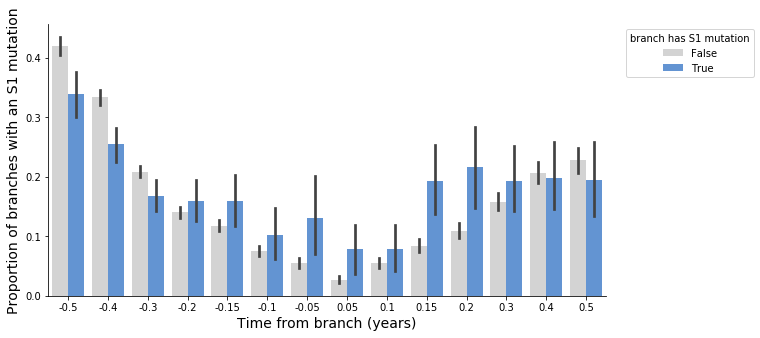

In [7]:
s1_mut_cmap = {True:"#5092E5", False:'#d3d3d3'}

fig, ax = plt.subplots(figsize=(10,5))

sns.barplot(x='timepoint', y='proportion_s1_mut', hue='node_has_s1_mut', 
            palette=s1_mut_cmap, data=df, ax=ax)

sns.despine(left=False, bottom=False)

ax.set_ylabel('Proportion of branches with an S1 mutation', fontsize = 14)
ax.set_xlabel('Time from branch (years)', fontsize = 14)

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='upper center', title='branch has S1 mutation', bbox_to_anchor=(1.15, 1.0))

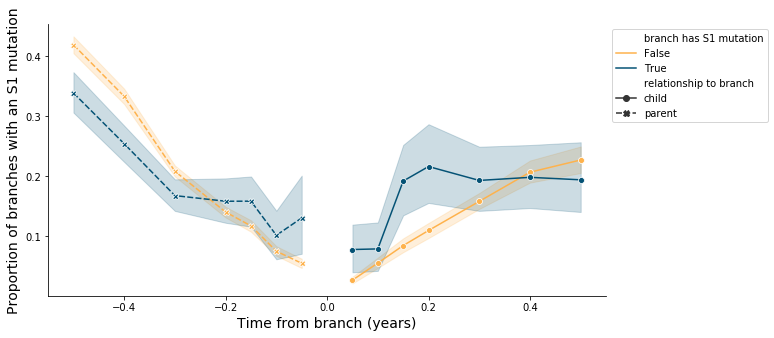

In [8]:
# spotlight_window_time = [0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5]  
# s1_mut_cmap = {True:"#5092E5", False:'#d3d3d3'}
s1_mut_cmap = {True:"#045275", False:'#FEB24C'}

fig, ax = plt.subplots(figsize=(10,5))

sns.lineplot(x='timepoint', y='proportion_s1_mut', hue='node_has_s1_mut', ci=95, 
             style='relationship_to_node', markers=True,
            palette=s1_mut_cmap, data=df, ax=ax)

sns.despine(left=False, bottom=False)

ax.set_ylabel('Proportion of branches with an S1 mutation', fontsize = 14)
ax.set_xlabel('Time from branch (years)', fontsize = 14)

handles, labels = ax.get_legend_handles_labels()

labels[0] = 'branch has S1 mutation'
labels[3] = 'relationship to branch'

lgd = ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(1.15, 1.0))

In [9]:
# spotlight_window_time = [0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5] 
# spotlight_window_time = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]  
spotlight_window_time = [0.05, 0.15, 0.2, 0.3, 0.4, 0.5] 


proportion_nodes_near_w_rdrp_mut = []

for node in tree.find_clades():


    if node.rdrp_muts_at_node == 0:
        has_rdrp_mut = False
    elif node.rdrp_muts_at_node > 0:
        has_rdrp_mut = True

    node_date = node.node_attrs['num_date']['value']

    
    # node_children_dict doesn't include root
    if node.name in node_children_dict.keys():
        node_children = node_children_dict[node.name]
        node_parents = get_parent(tree, node)[:-1]

        for spotlight_index in range(len(spotlight_window_time)):
            spotlight = spotlight_window_time[spotlight_index]
            if spotlight_index == 0:
                previous_spotlight = 0.0
            else:
                previous_spotlight = spotlight_window_time[spotlight_index-1]

            total_parents_in_spotlight = 0
            parents_w_rdrp_mut = 0

            for parent in node_parents:
                parent_date = parent.node_attrs['num_date']['value']

                if previous_spotlight <= (node_date - parent_date) <= spotlight:
                    total_parents_in_spotlight+=1

                    if parent.rdrp_muts_at_node == 0:
                        parent_has_rdrp_mut = False
                    elif parent.rdrp_muts_at_node > 0:
                        parents_w_rdrp_mut +=1

            # if there are any parents within this amount of time
            if total_parents_in_spotlight > 0:
                proportion_w_rdrp_mut = parents_w_rdrp_mut/total_parents_in_spotlight

                proportion_nodes_near_w_rdrp_mut.append({'timepoint':-spotlight, 
                                                    'proportion_rdrp_mut':proportion_w_rdrp_mut, 
                                                    'node_has_rdrp_mut': has_rdrp_mut,
                                                    'relationship_to_node': 'parent'})
                
                
            total_children_in_spotlight = 0
            children_w_rdrp_mut = 0

            for child in node_children:
                child_date = child.node_attrs['num_date']['value']

                if previous_spotlight <= (child_date - node_date) <= spotlight:
                    total_children_in_spotlight+=1

                    if child.rdrp_muts_at_node == 0:
                        child_has_rdrp_mut = False
                    elif child.rdrp_muts_at_node > 0:
                        children_w_rdrp_mut +=1

            # if there are any children within this amount of time
            if total_children_in_spotlight > 0:

                child_proportion_w_rdrp_mut = children_w_rdrp_mut/total_children_in_spotlight

                proportion_nodes_near_w_rdrp_mut.append({'timepoint':spotlight, 
                                                    'proportion_rdrp_mut': child_proportion_w_rdrp_mut, 
                                                    'node_has_rdrp_mut': has_rdrp_mut, 
                                                    'relationship_to_node': 'child'})


rdrp_df = pd.DataFrame(proportion_nodes_near_w_rdrp_mut)



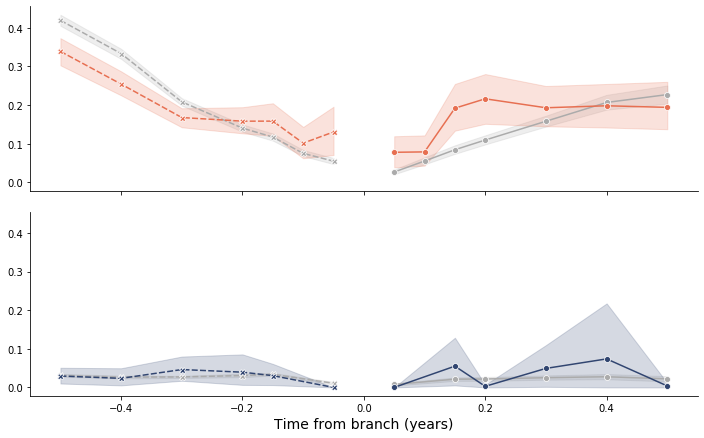

In [10]:
s1_mut_cmap = {True:"#E76F51", False:"#ABABAB"}
rdrp_mut_cmap = {True:"#314570", False:"#ABABAB"}

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,6), sharey=True, sharex=True)
plt.tight_layout()

sns.lineplot(x='timepoint', y='proportion_s1_mut', hue='node_has_s1_mut', ci=95, 
             style='relationship_to_node', markers=True,
            palette=s1_mut_cmap, data=df, ax=ax1, legend=False)


sns.lineplot(x='timepoint', y='proportion_rdrp_mut', hue='node_has_rdrp_mut', ci=95, 
             style='relationship_to_node', markers=True,
            palette=rdrp_mut_cmap, data=rdrp_df, ax=ax2, legend=False)



sns.despine(left=False, bottom=False)

# ax1.set_ylabel('Proportion of branches with a S1 mutation', fontsize = 12)
ax1.set_ylabel('', fontsize = 12)
ax2.set_ylabel('', fontsize = 12)
ax2.set_xlabel('Time from branch (years)', fontsize = 14)

fig.savefig('plots/spotlight_prevalence_muts_near_mut.png', dpi=300)

# handles1, labels1 = ax1.get_legend_handles_labels()

# labels1[0] = 'branch has S1 mutation'
# labels1[3] = 'relationship to branch'

# lgd = ax1.legend(handles1, labels1, loc='upper center')

# handles2, labels2 = ax2.get_legend_handles_labels()

# labels2[0] = 'branch has RdRp mutation'
# labels2[3] = 'relationship to branch'

# lgd = ax2.legend(handles2, labels2, loc='upper right')

The calculations plot the average proportion of parent or children branches that have S1 mutations. Now try binary (yes S1 mutation in window, no S1 mutation in window)

This didn't really change anything. 

In [11]:
spotlight_window_time = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]  

# spotlight_window_time = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4] 

# spotlight_window_time = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 
#                          0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0] 


# spotlight_window_time = [0.05, 0.1, 0.15, 0.2, 0.4, 0.6, 0.8] 

# proportion_nodes_w_mut = {f'minus_{x}':[] for x in spotlight_window_time}
s1_muts_near_nodes_w_mut = []

for node in tree.find_clades():
    
#     node_dict = {x:[] for x in spotlight_window_time}

    if node.s1_muts_at_node == 0:
        has_s1_mut = False
    elif node.s1_muts_at_node > 0:
        has_s1_mut = True

    node_date = node.node_attrs['num_date']['value']

    
    # node_children_dict doesn't include root
    if node.name in node_children_dict.keys():
        node_children = node_children_dict[node.name]
        node_parents = get_parent(tree, node)[:-1]

        for spotlight_index in range(len(spotlight_window_time)):
            spotlight = spotlight_window_time[spotlight_index]
            if spotlight_index == 0:
                previous_spotlight = 0.0
            else:
                previous_spotlight = spotlight_window_time[spotlight_index-1]

            total_parents_in_spotlight = 0
            parents_w_s1_mut = False

            for parent in node_parents:
                parent_date = parent.node_attrs['num_date']['value']

                if previous_spotlight <= (node_date - parent_date) <= spotlight:
                    total_parents_in_spotlight+=1

                    if parent.s1_muts_at_node > 0:
                        parents_w_s1_mut = True

            # if there are any parents within this amount of time
            if total_parents_in_spotlight > 0:

                s1_muts_near_nodes_w_mut.append({'timepoint':-spotlight, 
                                             'window_has_s1_mut': parents_w_s1_mut, 
                                             'node_has_s1_mut': has_s1_mut})
                
                
            total_children_in_spotlight = 0
            children_w_s1_mut = False

            for child in node_children:
                child_date = child.node_attrs['num_date']['value']

                if previous_spotlight <= (child_date - node_date) <= spotlight:
                    total_children_in_spotlight+=1

                    if child.s1_muts_at_node > 0:
                        children_w_s1_mut = True

            # if there are any children within this amount of time
            if total_children_in_spotlight > 0:

                child_proportion_w_s1_mut = children_w_s1_mut/total_children_in_spotlight

                s1_muts_near_nodes_w_mut.append({'timepoint':spotlight, 
                                                    'window_has_s1_mut': children_w_s1_mut, 
                                                    'node_has_s1_mut': has_s1_mut})


df = pd.DataFrame(s1_muts_near_nodes_w_mut)



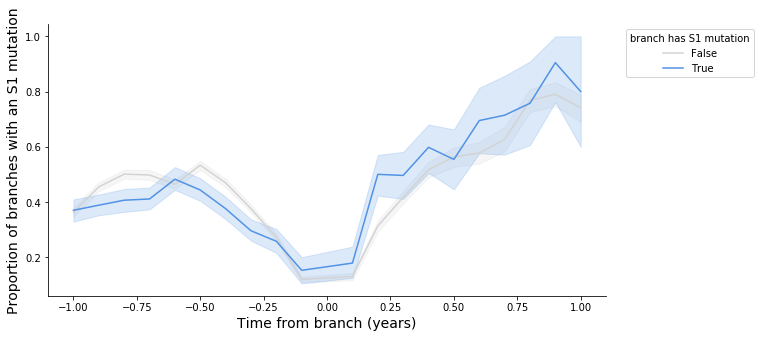

In [12]:
# spotlight_window_time = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]  
s1_mut_cmap = {True:"#5092E5", False:'#d3d3d3'}

fig, ax = plt.subplots(figsize=(10,5))

sns.lineplot(x='timepoint', y='window_has_s1_mut', hue='node_has_s1_mut', ci=95,
            palette=s1_mut_cmap, data=df, ax=ax)

sns.despine(left=False, bottom=False)

ax.set_ylabel('Proportion of branches with an S1 mutation', fontsize = 14)
ax.set_xlabel('Time from branch (years)', fontsize = 14)

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='upper center', title='branch has S1 mutation', bbox_to_anchor=(1.15, 1.0))